In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt

import scipy.io
import matplotlib.pyplot as plt

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.2+3.gaccabdfb


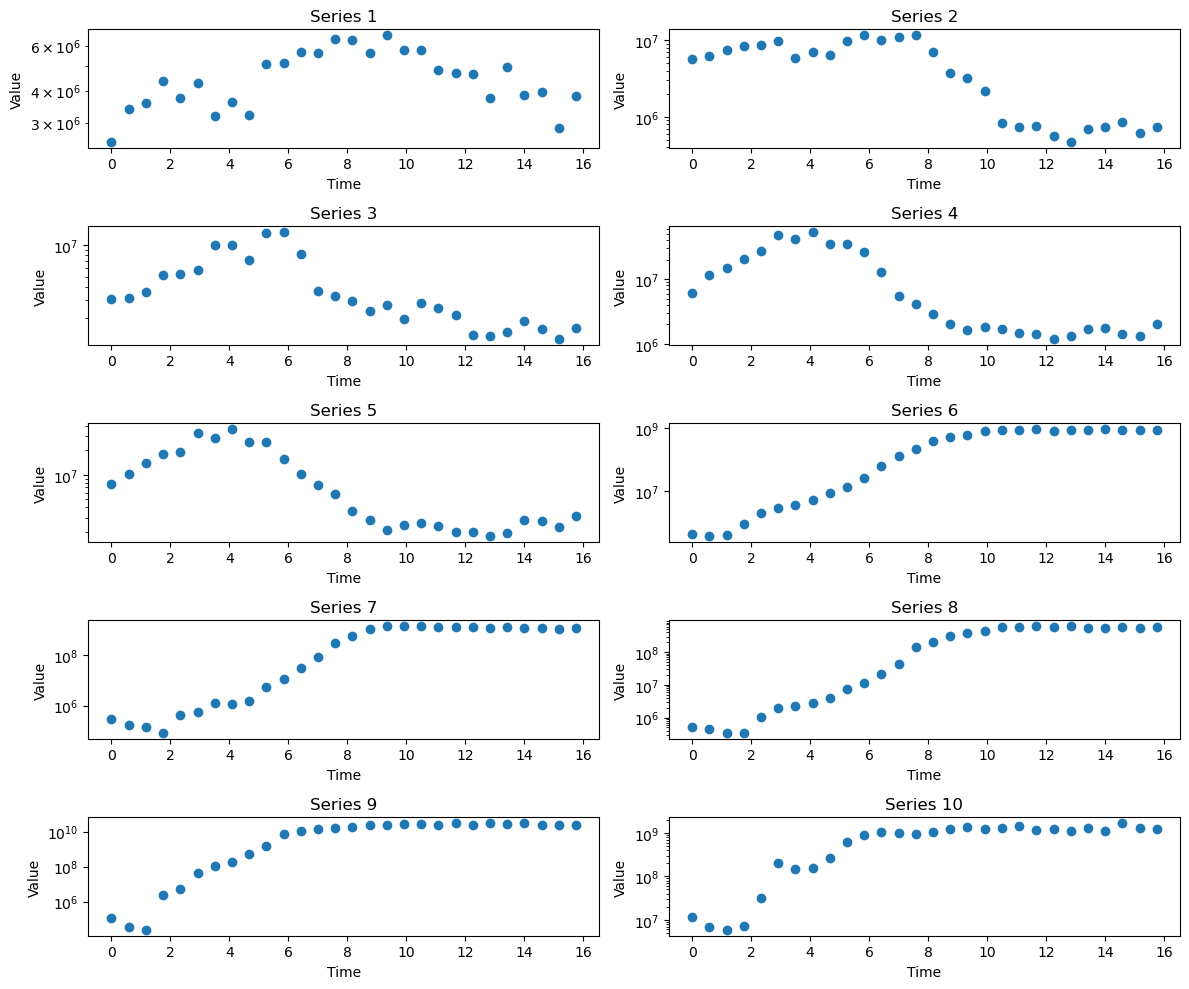

In [2]:


# Load the .mat file
mat_data = scipy.io.loadmat('./../data/qpcr.mat')

# Access the data struct
data = mat_data['data']

# Extract time data (assuming it's stored in data.xdata)
time = data['xdata'][0][0]

# Extract the 10 time series (assuming they are stored in data.ydata)
time_series = data['ydata'][0][0]

# Create subplots in a (5,2) grid
fig, axs = plt.subplots(5, 2, figsize=(12, 10))

# Flatten the axs array to make it easier to work with
axs = axs.flatten()

# Plot each time series on a logarithmic scale
for i in range(10):
    axs[i].plot(time, time_series[:, i],'o')
    axs[i].set_title(f'Series {i + 1}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
    axs[i].set_yscale('log')


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


### ODE based model.

In [3]:
import numpy as np
from numba import njit


## inside this function, every term has been made into a (N.M)-numpy array for matrix calculations





def seivd_mcmc(y,t,theta):
    
    
    # make these arrays (N,) --> (N,1) arrays, ie, vectors
    y = y.reshape(-1,1)
    
    # unpack parameters
    r1,r2,r3,r4,r5,beta12,beta21,beta22,beta23,beta33,beta44,beta45,beta54,beta55,phi12,phi21,phi22,phi23,phi33,phi44,phi45,phi54,phi55,tau12,tau21,tau22,tau23,tau33,tau44,tau45,tau54,tau55,Dc1,Dc2,Dc3,Dc4,Dc5= theta
    NE = 200
    NH = 5
    NV = 5
    
    # unpack variables 
    # these variables vary over time
    
    S = y[0:NH] # 1d vector
    Emat = y[NH : NH + NH*NV*NE]  #should be a 3d tensor
    Emat = Emat.reshape((NE,NH,NV)) # reshaped into a 3d tensor
    # Emat[i,:,:] is the i'th box -- so first element for the box number
    Imat = y[NH + NH*NV*NE : NH + NH*NV*NE + NH*NV] #2d matrix
    Imat = Imat.reshape((NH,NV))
    V = y[NH + NH*NV*NE + NH*NV : NH + NH*NV*NE + NH*NV + NV ]  #1d matrix
    D = y[NH + NH*NV*NE + NH*NV + NV] # a number
    
    

    
    
    # pack parameters into matrices.
    r = np.array([[r1,r2,r3,r4,r5]]).T #transposed it, so this is a column vector now.
    
    beta = np.array([[0, beta12, 0, 0, 0 ],
                     [beta21, beta22, beta23, 0, 0],
                     [0, 0, beta33, 0 , 0],
                     [0, 0, 0, beta44, beta45],
                     [0, 0, 0, beta54, beta55]])
    
    tau = np.array([[0, tau12, 0, 0, 0 ],
                     [tau21, tau22, tau23, 0, 0],
                     [0, 0, tau33, 0 , 0],
                     [0, 0, 0, tau44, tau45],
                     [0, 0, 0, tau54, tau55]])
    
    phi = np.array([[0, phi12, 0, 0, 0 ],
                     [phi21, phi22, phi23, 0, 0],
                     [0, 0, phi33, 0 , 0],
                     [0, 0, 0, phi44, phi45],
                     [0, 0, 0, phi54, phi55]])
    

    
    Dc = np.array([[Dc1,Dc2,Dc3,Dc4,Dc5]]).T
    #etaeff = (NE+1) * np.where(tau != 0, 1 / tau, 0)  # tested: works fine
    etaeff = (NE+1)*np.array([[0, 1/tau12, 0, 0, 0 ],
                     [1/tau21, 1/tau22, 1/tau23, 0, 0],
                     [0, 0, 1/tau33, 0 , 0],
                     [0, 0, 0, 1/tau44, 1/tau45],
                     [0, 0, 0, 1/tau54, 1/tau55]])
    

    
    #set up variables for the differential equation
    Sdeb = S/(1+(D/Dc)**2) #element wise division
    N = S + np.sum(Emat,axis=0)@np.ones((NV,1)) + Imat@np.ones((NV,1))  #sum of all the different types of host cells (is a column vector of same size as S)
    # we summed the 0 axis, for boxes, then we multiplied with a col vector of size NV, means summed at each row level
    # means at each row, summed elements of each columns, so viruses summer up, and we net N_i for each host
    Ndeb = N/(1+(D/Dc)**2) #number of host of each species scaled by debris factor.
    
    
    
    ## the differential eqauations
    dS = r*S - Sdeb * (phi@V) #host change
    
    dEmat = np.zeros((NE,NH,NV)) # initializing as zero tensor, otherwise will give undefined error
    #dEmat[0,:,:] = Sdeb * ((phi*beta)@V) - etaeff*Emat[0,:,:]
    #dEmat[0,:,:] =  phi*(Sdeb@V.T) - etaeff*Emat[0,:,:]
    dEmat[0,:,:] = (phi*(Sdeb@V.T) - etaeff*Emat[0,:,:]).reshape((NH, NV))

    
    #vectorize this
    dEmat[1:,:,:] = etaeff * (-Emat[1:,:,:] + Emat[0:-1,:,:])  # note the signs 
    dImat = etaeff * (Emat[NE-1,:,:] - Imat) #element wise multiplication
    
    # for the viruses we need to sum up all the row elements for each column 
    # sum_{j=1}^{NH} Imat'_{kj} = Imat_k 
    #for the part of viral ads, transpose phi and multiply, as sum over the hosts
    dV = (beta * etaeff * Imat).T @ np.ones((NH,1)) - V * (phi.T @ Ndeb)
    dD = np.sum(etaeff* Imat)
    
    
    dydt = np.concatenate((dS.flatten(), dEmat.flatten(), dImat.flatten(), dV.flatten(), [dD]))
    return dydt

In [4]:
from scipy.integrate import odeint


NE = 200
NH = 5
NV = 5

y0 = np.zeros((NH + NH*NV*NE + NH*NV + NV + 1))

y0[0] = 2.5111e+06
y0[1] = 5.6423e+06
y0[2] = 3.0257e+06
y0[3] = 6.205e+06
y0[4] = 7.7533e+06

y0[-6] = 4.2887e+05
y0[-5] = 2.8689e+05
y0[-4] = 5.28e+05
y0[-3] = 1.1033e+05
y0[-2] = 1.151e+07



## Bayesian inference using pymc

In [5]:
import pymc as pm

In [6]:

az.style.use("arviz-darkgrid")

In [7]:
theta= np.array([0.18, 0.25, 0.3, 0.68, 0.52, 1.7, 200, 205, 100,20, 522,60,485,50,
                 0.6e-7, 0.18e-7,0.8e-7,0.2e-7,0.6e-7,0.7e-7,0.1285e-7,0.6e-7,0.22e-7,
                 3,1.7,2.7,2.3,2,1.8,4.7,2.3,2,
                 5e6,6.13e6,16e6,17.3e5,15.5e5])
    

y = odeint(func=seivd_mcmc, y0=y0, t=time.flatten(), args=(theta,))
t = time.flatten()
host = y[:,0:NH] + np.sum(np.sum( y[:,NH : NH + NH*NV*NE].reshape((len(t),200,5,5)),axis = 3),axis=1) + np.sum(y[:,NH + NH*NV*NE : NH + NH*NV*NE + NH*NV].reshape(len(t),5,5),axis = 2 ) 
virus = y[:,-1-NV:-1]
np.concatenate((host,virus),axis =1)

array([[2.51110000e+06, 5.64230000e+06, 3.02570000e+06, 6.20500000e+06,
        7.75330000e+06, 4.28870000e+05, 2.86890000e+05, 5.28000000e+05,
        1.10330000e+05, 1.15100000e+07],
       [2.78784752e+06, 6.51820451e+06, 3.59919938e+06, 9.09223881e+06,
        1.03037510e+07, 4.02383944e+05, 1.96984432e+05, 4.38164660e+05,
        5.91133896e+04, 9.68937574e+06],
       [3.09311001e+06, 7.51299277e+06, 4.27200179e+06, 1.30767838e+07,
        1.33494722e+07, 3.73850466e+05, 1.28175877e+05, 3.51933310e+05,
        2.50047779e+04, 7.67223302e+06],
       [3.43063759e+06, 8.64436489e+06, 5.06351794e+06, 1.86635947e+07,
        1.70817774e+07, 1.01468622e+06, 7.84815577e+04, 2.75324621e+05,
        6.21944390e+05, 5.77602393e+06],
       [3.80448732e+06, 9.89622828e+06, 5.96389780e+06, 2.59910322e+07,
        2.07613008e+07, 5.72258792e+06, 8.07238176e+04, 1.23835209e+06,
        7.47044645e+06, 3.25748568e+07],
       [4.21210923e+06, 1.11609630e+07, 6.96337743e+06, 3.31717559e+07,
   

In [11]:
time_series.shape


(28, 10)

In [ ]:
1+1

In [12]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    y = odeint(func=seivd_mcmc, y0=y0, t=time.flatten(), args=(theta,))
    t = time.flatten()
    host = y[:,0:NH] + np.sum(np.sum( y[:,NH : NH + NH*NV*NE].reshape((len(t),200,5,5)),axis = 3),axis=1) + np.sum(y[:,NH + NH*NV*NE : NH + NH*NV*NE + NH*NV].reshape(len(t),5,5),axis = 2 ) 
    virus = y[:,-1-NV:-1]
    
    return np.concatenate((host,virus),axis=1)
    

In [13]:
with pm.Model() as model:
    
    # Priors for parameters
    
    r1 = pm.Normal("r1", mu = 0.18, sigma = 0.2)
    r2 = pm.Normal("r2", mu = 0.25, sigma = 0.2)
    r3 = pm.Normal("r3", mu = 0.3, sigma = 0.2)
    r4 = pm.Normal("r4", mu = 0.68, sigma = 0.2)
    r5 = pm.Normal("r5", mu = 0.52, sigma = 0.2)
    
    beta12 = pm.Normal("beta12", mu = 1.7, sigma = 1)
    beta21 = pm.Normal("beta21", mu = 200, sigma = 100)
    beta22 = pm.Normal("beta22", mu = 206, sigma = 100)
    beta23 = pm.Normal("beta23", mu = 100, sigma = 100) 
    beta33 = pm.Normal("beta33", mu = 20, sigma = 20)
    beta44 = pm.Normal("beta44", mu = 522, sigma = 200)
    beta45 = pm.Normal("beta45", mu = 60, sigma = 50)
    beta54 = pm.Normal("beta54", mu = 485, sigma = 200)
    beta55 = pm.Normal("beta55", mu = 50, sigma = 40)
    

    phi12 = pm.Normal("phi12", mu = 0.6e-7, sigma = 1e-8)
    phi21 = pm.Normal("phi21", mu = 0.18e-7, sigma = 1e-8)
    phi22 = pm.Normal("phi22", mu = 0.8e-7, sigma = 1e-8)
    phi23 = pm.Normal("phi23", mu = 0.2e-7, sigma = 1e-8)
    phi33 = pm.Normal("phi33", mu = 0.6e-7, sigma = 1e-8)
    phi44 = pm.Normal("phi44", mu = 0.7e-7, sigma = 1e-8)
    phi45 = pm.Normal("phi45", mu = 0.1285e-7, sigma = 1e-8)
    phi54 = pm.Normal("phi54", mu = 0.6e-7, sigma = 1e-8)
    phi55 = pm.Normal("phi55", mu = 0.22e-7, sigma = 1e-8)
    
    tau12 = pm.Normal("tau12", mu = 3, sigma = 2)
    tau21 = pm.Normal("tau21", mu = 1.7, sigma = 2)
    tau22 = pm.Normal("tau22", mu = 2.7, sigma = 2)
    tau23 = pm.Normal("tau23", mu = 2.3, sigma = 2) 
    tau33 = pm.Normal("tau33", mu = 2, sigma = 2)
    tau44 = pm.Normal("tau44", mu = 1.8, sigma = 2)
    tau45 = pm.Normal("tau45", mu = 4.7, sigma = 2)
    tau54 = pm.Normal("tau54", mu = 2.3, sigma = 2)
    tau55 = pm.Normal("tau55", mu = 2, sigma = 4)
    
    Dc1 = pm.Normal("Dc1", mu = 5e6 ,sigma = 5e5)
    Dc2 = pm.Normal("Dc2", mu = 6.13e6 ,sigma = 5e5)
    Dc3 = pm.Normal("Dc3", mu = 16e6 ,sigma = 5e5)
    Dc4 = pm.Normal("Dc4", mu = 17.3e5 ,sigma = 5e5)
    Dc5 = pm.Normal("Dc5", mu = 15.5e5 ,sigma = 5e5)
    
    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(pm.math.stack([r1, r2, r3, r4, r5, beta12, beta21, beta22, beta23, beta33, beta44, beta45, beta54, beta55, phi12, phi21, phi22, phi23, phi33, phi44, phi45, phi54, phi55, tau12, tau21, tau22, tau23, tau33, tau44, tau45, tau54, tau55, Dc1, Dc2, Dc3, Dc4, Dc5]))
    
    
    
    # Define your likelihood
    #sigma = pm.InverseGamma("sigma", alpha=1, beta=1)
    sigma = pm.Normal("sigma", 10)
    obs = pm.Normal("obs", mu=ode_solution, sigma=sigma, observed=time_series)



In [14]:
y0

array([ 2511100.,  5642300.,  3025700., ...,   110330., 11510000.,
              0.])

In [ ]:

# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]

# Specify the sampler
sampler = "Slice Sampler"
tune = draws = 2000

# Inference!
with model:
    trace_slice = pm.sample(step=[pm.Slice(vars_list)], tune=tune, draws=draws, chains=2,cores=1,return_inferencedata=True)
trace = trace_slice
az.summary(trace)

az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [r1]
>Slice: [r2]
>Slice: [r3]
>Slice: [r4]
>Slice: [r5]
>Slice: [beta12]
>Slice: [beta21]
>Slice: [beta22]
>Slice: [beta23]
>Slice: [beta33]
>Slice: [beta44]
>Slice: [beta45]
>Slice: [beta54]
>Slice: [beta55]
>Slice: [phi12]
>Slice: [phi21]
>Slice: [phi22]
>Slice: [phi23]
>Slice: [phi33]
>Slice: [phi44]
>Slice: [phi45]
>Slice: [phi54]
>Slice: [phi55]
>Slice: [tau12]
>Slice: [tau21]
>Slice: [tau22]
>Slice: [tau23]
>Slice: [tau33]
>Slice: [tau44]
>Slice: [tau45]
>Slice: [tau54]
>Slice: [tau55]
>Slice: [Dc1]
>Slice: [Dc2]
>Slice: [Dc3]
>Slice: [Dc4]
>Slice: [Dc5]
>Slice: [sigma]


In [ ]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot");

In [ ]:
pm.summary(trace)

In [ ]:
pm.summary(trace, var_names=["phi12"])

In [ ]:
az.plot_trace(trace,var_names=["phi12"], kind="rank_bars")